In [110]:
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa as lb
import IPython
import scipy.signal
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from IPython.lib.display import Audio
from scipy.signal import butter, lfilter, freqz

In [96]:
file_path = "C:/Users/Jayde/Desktop/Datasets/sc09/sc09/nine/0a2b400e_nohash_2.wav"
signal, sr = lb.load(file_path)
print(sr)
IPython.display.display(Audio(signal, rate =sr))

22050


In [97]:
def bandpass_filter(data, low, high, sr, order=5):
    nyquist = sr/2
    low = low/nyquist
    high = high/nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered = lfilter(b, a, data)
    return filtered

In [98]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


Text(0.5, 0, 'Frequency [Hz]')

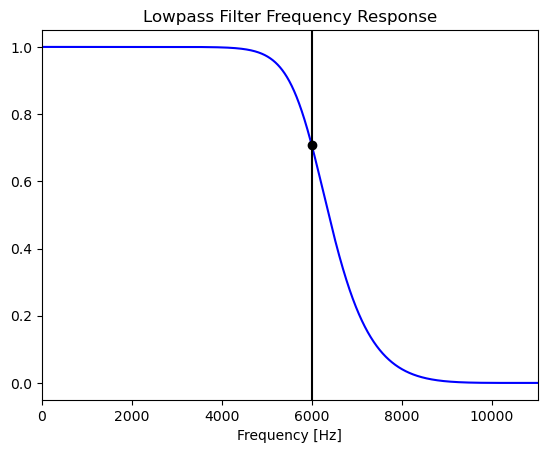

In [112]:
cutoff = 6000
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, sr, order=5)

# Plot the frequency response.
w, h = freqz(b, a, fs=sr, worN=8000)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*sr)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')

In [114]:
signal = butter_lowpass_filter(signal,cutoff,sr)
IPython.display.display(Audio(signal, rate =sr))

In [115]:
#extract spectrogram
FRAME_SIZE=1024
HOP_SIZE = 512
spec = lb.stft(signal, n_fft=FRAME_SIZE, hop_length= HOP_SIZE)

In [116]:
spec.shape

(513, 44)

In [117]:
#calculate band energy ratio
def calculate_split_frequency_bin(spec,split_frequency,sr):
    nq_freq = sr/2
    frequency_delta_per_bin = nq_freq / spec.shape[0] #spec.shape[0] is the number of freq bins

    #mapping split frequency onto the closest bin
    split_freq_bin = int(np.floor(split_frequency / frequency_delta_per_bin))
    return split_freq_bin

In [118]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(spectrogram, split_frequency, sr)
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T #.T does the transpose
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [119]:
ber = band_energy_ratio(spec, 1000, sr)

In [120]:
frames = range(len(ber))
t = lb.frames_to_time(frames, hop_length=HOP_SIZE)

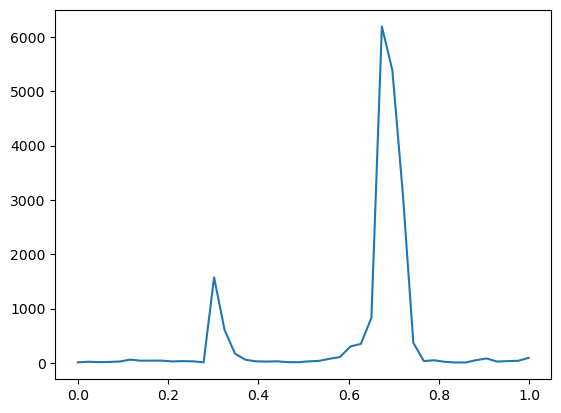

In [121]:
plt.plot(t, ber)
plt.show()


In [122]:
def create_fft(signal,sr, font_size = 13):
    n_samples = len(signal)
    nyquist_freq = sr/2 #max freq
    #using rfft as it only computes the useful half of the fft to speed up processing
    amplitudes = np.abs(rfft(signal))
    frequencies = rfftfreq(n_samples, 1/sr)
    fundamental_freq_index = np.argmax(amplitudes)
    fundamental_freq= frequencies[fundamental_freq_index]
    print(f"Fundamental Frequency- {fundamental_freq} Hz")
    plt.plot(frequencies, amplitudes, linewidth=0.4)
    #plot vertical line
    plt.axvline(x = fundamental_freq, color = 'red', linestyle= '--', label = "Fundamental Frequency", linewidth = 0.1)
    plt.xlabel('Frequency (Hz)', fontsize= font_size)
    plt.ylabel('Amplitude', fontsize= font_size)
    plt.xlim(0,nyquist_freq)
    plt.legend()
    plt.show()


Fundamental Frequency- 285.0 Hz


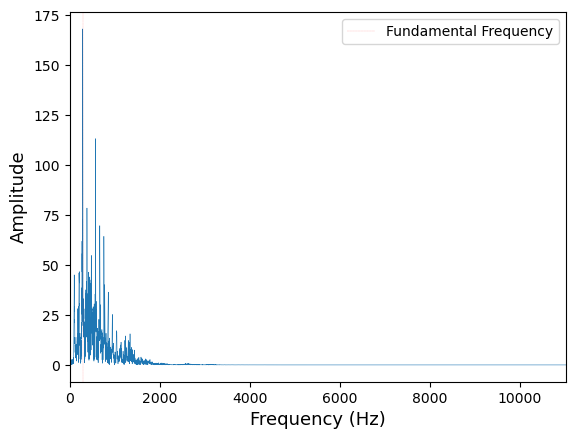

In [123]:
create_fft(signal,sr)

570.4518077804643


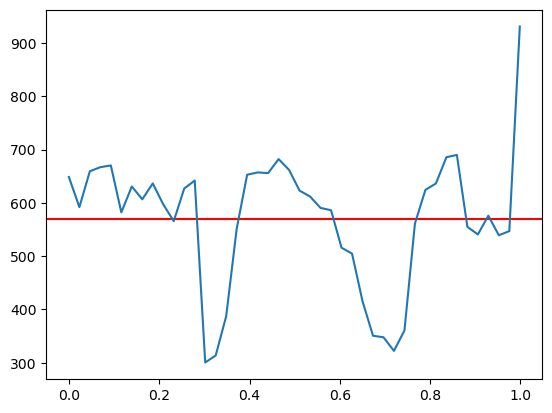

In [126]:
#spectral centroid
sc = lb.feature.spectral_centroid(y = signal, sr=sr, n_fft= FRAME_SIZE, hop_length=HOP_SIZE)[0]
frames = range(len(sc))
t = lb.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)
avg = np.mean(sc)
print(avg)
sc_plus = [sc[i]+sb[i] for i in range(len(sc))]
sc_min = [sc[i]-sb[i] for i in range(len(sc))]
plt.axhline(avg, color = 'r')
plt.plot(t,sc)
#plt.plot(t,sc_plus, linestyle = '--')
#plt.plot(t,sc_min, linestyle = '--')
#create_sprectrogram(signal,sr)
plt.show()

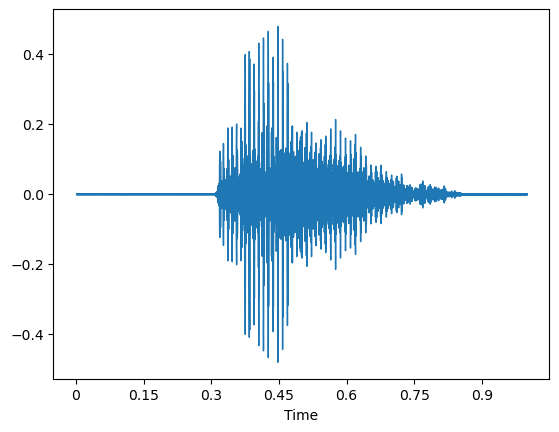

In [130]:
IPython.display.display(Audio(signal, rate =sr))
lb.display.waveshow(signal, sr=sr)

In [124]:
sb = lb.feature.spectral_bandwidth(y = signal, sr=sr, n_fft= FRAME_SIZE, hop_length=HOP_SIZE)[0]

In [90]:
def create_sprectrogram(signal, sr, n_overlap= None, window_length=1024):
    if n_overlap ==None:
        n_overlap = window_length-64
    f_bins, t_bins, Sxx = spectrogram(signal, fs=sr,
                                 window='hann', nperseg=window_length,
                                 noverlap=n_overlap, detrend=False,
                                 scaling='spectrum')
    plt.pcolormesh(t_bins, f_bins, 20*np.log10(Sxx+1e-100), cmap='magma')
    #plt.colorbar()
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    #plt.ylim([0, 7500])
    #plt.show()